<div style="text-align: center"> <h1> Assignment - 10

<div style="text-align: center"> <h3>CS677 A1 Data Science with Python (Fall 2024)

<div style="text-align: center"> <h4>Submitted by: Aishwarya Malhotra (U17161095)</div>

### **Part - 1 : Naive Bayes (Student-t)**

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import t
from sklearn.metrics import confusion_matrix, accuracy_score

In [14]:
df = pd.read_excel("META_weekly_return_detailed.xlsx")

In [15]:
# Looking at the dataframe
df

,Open,High,Low,Close,Adj Close,Volume,Return,Date,Week_Number,Year,Day,Weekday,mean_return,volatility,Label
0,358.989990,360.000000,351.820007,353.959992,352.897461,14980500,-1.217,2023-12-29,52,2023,29,Friday,0.043000,0.889220,Green
1,359.700012,361.899994,357.809998,358.320007,357.244385,11798800,0.137,2023-12-28,52,2023,28,Thursday,0.043000,0.889220,Green
2,356.070007,359.000000,355.309998,357.829987,356.755859,13207900,0.845,2023-12-27,52,2023,27,Wednesday,0.043000,0.889220,Green
3,354.989990,356.980011,353.450012,354.829987,353.764832,9898600,0.407,2023-12-26,52,2023,26,Tuesday,0.043000,0.889220,Green
4,355.579987,357.200012,351.220001,353.390015,352.329193,11764200,-0.198,2023-12-22,51,2023,22,Friday,1.086600,1.349914,Green
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,139.889999,143.139999,139.539993,142.529999,142.102158,26263800,3.245,2019-01-08,1,2019,8,Tuesday,0.842400,1.456660,NaN
1254,137.559998,138.869995,135.910004,138.050003,137.635590,20089300,0.072,2019-01-07,1,2019,7,Monday,0.842400,1.456660,NaN
1255,134.009995,138.000000,133.750000,137.949997,137.535889,29002100,4.714,2019-01-04,0,2019,4,Friday,0.603333,3.844670,NaN
1256,134.690002,137.169998,131.119995,131.740005,131.344528,22717900,-2.904,2019-01-03,0,2019,3,Thursday,0.603333,3.844670,NaN


In [16]:
feature_values = df[df['Year'].isin([2022, 2023])].groupby(['Week_Number', 'Year']).agg(
    mean = ('mean_return', lambda x: round(x.mean()* 100,2)),
    std = ('Return', lambda x: round(x.std()* 100,2)),
    Label = ('Label', 'first'),
).reset_index()

feature_values.head(10)

# Split data into Year 1 and Year 2
year_1 = feature_values[feature_values['Year'] == 2022]
year_2 = feature_values[feature_values['Year'] == 2023]

In [17]:
feature_values

,Week_Number,Year,mean,std,Label
0,1,2022,-25.22,226.54,Red
1,1,2023,196.30,167.29,Green
2,2,2022,1.86,172.80,Red
3,2,2023,105.88,160.29,Green
4,3,2022,-221.70,234.53,Red
...,...,...,...,...,...
99,50,2023,14.30,180.34,Green
100,51,2022,-20.06,286.58,Green
101,51,2023,108.66,134.99,Green
102,52,2022,50.48,239.57,Green


In [18]:
# Features and labels
X_train = year_1[['mean', 'std']]
y_train = year_1['Label']
X_test = year_2[['mean', 'std']]
y_test = year_2['Label']

In [19]:
# Define initial capital
initial_capital = 100

# Buy-and-Hold strategy
cumulative_return = year_2['mean'].sum() / 100  # Sum of weekly returns, converted to decimal
capital_buy_and_hold = initial_capital * (1 + cumulative_return)

print("Final Amount with Buy-and-Hold Strategy: ${:.2f}".format(capital_buy_and_hold))

Final Amount with Buy-and-Hold Strategy: $2509.98


##### **Solution - 1, 2, 3, 4**

In [20]:
from scipy import stats
# Define possible degrees of freedom for Student-t
dfs = [0.5, 1, 5]

def naive_bayes_student_t(X_train, y_train, X_test, df):
    # 1. Calculate mean and std for each class
    class_stats = {}
    for label in y_train.unique():
        class_data = X_train[y_train == label]
        mean_mean = class_data['mean'].mean()
        std_mean = class_data['mean'].std()
        mean_std = class_data['std'].mean()
        std_std = class_data['std'].std()

        # Calculate prior probability for the class
        prior = len(class_data) / len(X_train)

        # Store the class statistics
        class_stats[label] = {
            'prior': prior,
            'mean_mean': mean_mean,
            'std_mean': std_mean,
            'mean_std': mean_std,
            'std_std': std_std,
        }

    # 2. Classify test data
    predictions = []
    for _, row in X_test.iterrows():
        mean = row['mean']
        std = row['std']
        probs = {}

        for label, stats_dict in class_stats.items():
            # Compute the probability of the class for the given data point
            mean_prob = stats_dict['prior'] * stats.t.pdf(mean, df, loc=stats_dict['mean_mean'], scale=stats_dict['std_mean'])
            std_prob = stats_dict['prior'] * stats.t.pdf(std, df, loc=stats_dict['mean_std'], scale=stats_dict['std_std'])
            probs[label] = mean_prob * std_prob  # Multiply probabilities for Naive Bayes

        # Choose the label with the highest probability
        predictions.append(max(probs, key=probs.get))

    return predictions


In [21]:
# Evaluate classifier for each df and print results
best_df = None
best_accuracy = 0
results = {}

for df in dfs:
    # Predict labels for the test set
    y_pred = naive_bayes_student_t(X_train, y_train, X_test, df)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred, labels=['Red', 'Green'])
    tp_rate = conf_matrix[1, 1] / conf_matrix[1].sum()  # True positive rate
    tn_rate = conf_matrix[0, 0] / conf_matrix[0].sum()  # True negative rate

    # Print results for this df
    print(f"Results for df = {df}:")
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"True Positive Rate: {tp_rate}")
    print(f"True Negative Rate: {tn_rate}\n")

    # Track the best df
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_df = df
    results[df] = {'accuracy': accuracy, 'tp_rate': tp_rate, 'tn_rate': tn_rate}

print(f"Best df: {best_df} with accuracy: {best_accuracy}")

Results for df = 0.5:
Accuracy: 0.6923076923076923
Confusion Matrix:
[[ 2 16]
 [ 0 34]]
True Positive Rate: 1.0
True Negative Rate: 0.1111111111111111

Results for df = 1:
Accuracy: 0.6538461538461539
Confusion Matrix:
[[ 0 18]
 [ 0 34]]
True Positive Rate: 1.0
True Negative Rate: 0.0

Results for df = 5:
Accuracy: 0.6538461538461539
Confusion Matrix:
[[ 0 18]
 [ 0 34]]
True Positive Rate: 1.0
True Negative Rate: 0.0

Best df: 0.5 with accuracy: 0.6923076923076923


##### **Solution - 5. Comparison of Buy & Hold with Normal Naive Bayes**

In [22]:
# Trading strategy evaluation for the best df
y_pred_best = naive_bayes_student_t(X_train, y_train, X_test, best_df)
initial_balance = 100 # Starting capital
balance = initial_balance

for i, label in enumerate(y_pred_best):
   if label == 'Green':
        balance *= (1 + year_2.iloc[i]['mean'] / 100)  # Update balance based on weekly return


print(f"Balance with Naive Bayes strategy: ${balance:.2f}")
print(f"Balance with buy-and-hold strategy: ${capital_buy_and_hold:.2f}")


# Determine which strategy yields better results
if cumulative_return > capital_buy_and_hold:
    print("The trading strategy based on Naive Bayes predictions results in a larger amount.")
else:
    print("The buy-and-hold strategy results in a larger amount compared to Naive Bayes.")

Balance with Naive Bayes strategy: $59638.53
Balance with buy-and-hold strategy: $2509.98
The buy-and-hold strategy results in a larger amount compared to Naive Bayes.


### **Part - 2 Decision Tree**

##### **Solution - 1. Implement a Decision Tree and Compute Its Accuracy for Year 2**

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Initialize the Decision Tree Classifier with entropy as the splitting criterion
dt_classifier = DecisionTreeClassifier(criterion="entropy", random_state=0)

# Fit the model on year 1 data
dt_classifier.fit(X_train, y_train)

# Predict labels for year 2
y_pred = dt_classifier.predict(X_test)

# Compute accuracy for year 2
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for Year 2:", accuracy)


Accuracy for Year 2: 0.4423076923076923


##### **Solution - 2. Compute the Confusion Matrix for Year 2**

In [24]:
# Calculate the confusion matrix for year 2
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix for Year 2:\n", conf_matrix)

Confusion Matrix for Year 2:
 [[10 24]
 [ 5 13]]


##### **Solution - 3. Compute the True Positive Rate and True Negative Rate for Year 2**

In [25]:
# Extract confusion matrix values
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate true positive rate and true negative rate
true_positive_rate = tp / (tp + fn)
true_negative_rate = tn / (tn + fp)

print("True Positive Rate for Year 2:", true_positive_rate)
print("True Negative Rate for Year 2:", true_negative_rate)


True Positive Rate for Year 2: 0.7222222222222222
True Negative Rate for Year 2: 0.29411764705882354


##### **Solution - 4. Implement a Trading Strategy Based on Year 2 Predictions and Compare to Buy-and-Hold**

In [26]:
# Define initial capital for both strategies

initial_capital = 100

# Trading strategy returns based on model predictions
capital_trading_strategy = initial_capital
for label, mean_return in zip(y_pred, year_2['mean']):
    if label == "Green":  # Buy signal
        capital_trading_strategy *= (1 + mean_return / 100)

print("Final Amount with Trading Strategy - Regression Tree: ${:.2f}".format(capital_trading_strategy))
print("Final Amount with Buy-and-Hold Strategy: ${:.2f}".format(capital_buy_and_hold))

# Compare which strategy results in a larger amount
if capital_trading_strategy > capital_buy_and_hold:
    print("The Trading Strategy - Regression Tree outperformed the Buy-and-Hold Strategy.")
else:
    print("The Buy-and-Hold Strategy outperformed the Trading Strategy - Regression Tree.")

Final Amount with Trading Strategy - Regression Tree: $2522.08
Final Amount with Buy-and-Hold Strategy: $2509.98
The Trading Strategy - Regression Tree outperformed the Buy-and-Hold Strategy.


### **Part - 4 Random Forest**

##### **Solution - 1**

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

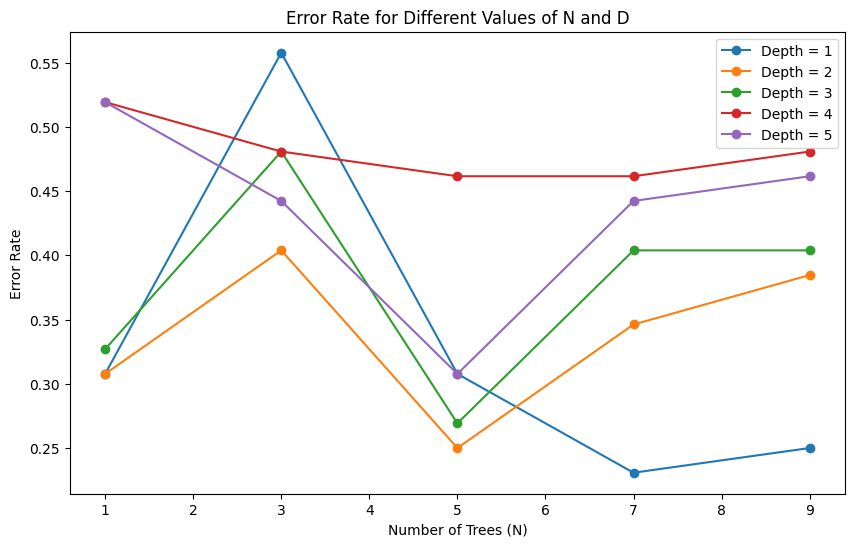

Best combination: N = 7.0, D = 1.0


In [28]:
# Define parameters
N_values = [1, 3, 5, 7, 9]
D_values = [1, 2, 3, 4, 5]
error_rates = []

# Train and evaluate models with different (N, d) combinations
for N in N_values:
    for d in D_values:
        # Initialize Random Forest with specific N and d
        rf = RandomForestClassifier(n_estimators=N, max_depth=d, criterion='entropy', random_state=0)
        rf.fit(X_train, y_train)

        # Predict and calculate error rate for year 2
        y_pred = rf.predict(X_test)
        error_rate = 1 - accuracy_score(y_test, y_pred)
        error_rates.append((N, d, error_rate))

# Convert error rates to a DataFrame for easier plotting
error_df = pd.DataFrame(error_rates, columns=['N', 'D', 'Error_Rate'])

# Plot error rates
plt.figure(figsize=(10, 6))
for d in D_values:
    subset = error_df[error_df['D'] == d]
    plt.plot(subset['N'], subset['Error_Rate'], marker='o', label=f'Depth = {d}')
plt.xlabel('Number of Trees (N)')
plt.ylabel('Error Rate')
plt.title('Error Rate for Different Values of N and D')
plt.legend()
plt.show()

# Find the best (N, D) combination with the lowest error rate
best_combination = error_df.loc[error_df['Error_Rate'].idxmin()]
best_N = best_combination['N']
best_D = best_combination['D']
print(f"Best combination: N = {best_N}, D = {best_D}")

##### **Solution - 2**

In [29]:
# Using the best combination, compute the confusion matrix, TPR, TNR, and compare strategies

# Train with optimal N and D
rf_best = RandomForestClassifier(n_estimators=int(best_N), max_depth=int(best_D), criterion='entropy', random_state=0)
rf_best.fit(X_train, y_train)
y_pred_best = rf_best.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best, labels=['Green', 'Red'])
tn, fp, fn, tp = conf_matrix.ravel()
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[33  1]
 [11  7]]


##### **Solution - 3**

In [30]:
# True Positive Rate and True Negative Rate
tpr = tp / (tp + fn)  # Sensitivity or Recall
tnr = tn / (tn + fp)  # Specificity
print(f"True Positive Rate: {tpr}")
print(f"True Negative Rate: {tnr}")

True Positive Rate: 0.3888888888888889
True Negative Rate: 0.9705882352941176


##### **Solution - 4**

In [31]:
initial_capital = 100
capital_trading_strategy = initial_capital

# Cap maximum weekly return to prevent compounding errors
max_return_limit = 0.5  # Set a limit for weekly return, e.g., 50%

# Simulate the trading strategy with capped returns
for label, mean_return in zip(y_pred_best, year_2['mean']):
    if label == "Green":  # Buy signal
        # Limit the mean return to avoid large negative or extreme compounding
        mean_return = min(max_return_limit, max(-max_return_limit, mean_return))
        capital_trading_strategy *= (1 + mean_return / 100)

print("Final Amount with Trading Strategy - Random Forest: ${:.2f}".format(capital_trading_strategy))
print("Final Amount with Buy-and-Hold Strategy: ${:.2f}".format(capital_buy_and_hold))

# Compare which strategy results in a larger amount
if capital_trading_strategy > capital_buy_and_hold:
    print("The Trading Strategy - Random Forest outperformed the Buy-and-Hold Strategy.")
else:
    print("The Buy-and-Hold Strategy outperformed the Trading Strategy - Random Forest.")


Final Amount with Trading Strategy - Random Forest: $113.82
Final Amount with Buy-and-Hold Strategy: $2509.98
The Buy-and-Hold Strategy outperformed the Trading Strategy - Random Forest.


### **Part - 4 AdaBoost**

##### **Solution - 1**

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [33]:
# Define parameters
lambdas = [0.5, 1]
N_values = range(1, 16)
base_estimators = {
    'Logistic Regression': LogisticRegression(max_iter=100),
    'Naive Bayes': GaussianNB(),
    }

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

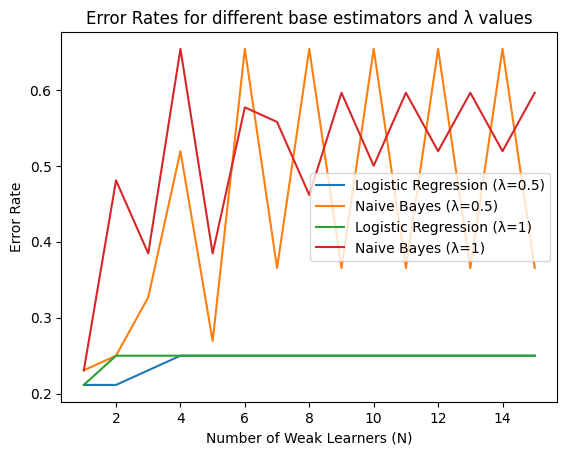

In [34]:
# Initialize error rates and accuracies storage
error_rates = {}
accuracies = {}
best_N = {}

# Iterate over different values of lambda and base estimators
for lr in lambdas:
    error_rates[lr] = {}
    accuracies[lr] = {}
    for name, estimator in base_estimators.items():
        errors = []
        for n in N_values:
            adaboost = AdaBoostClassifier(estimator=estimator, n_estimators=n, learning_rate=lr, random_state=0)
            adaboost.fit(X_train, y_train)
            y_pred = adaboost.predict(X_test)
            error_rate = 1 - accuracy_score(y_test, y_pred)
            errors.append(error_rate)

        error_rates[lr][name] = errors

        # Identify the best N for this estimator
        best_N[name] = N_values[np.argmin(errors)]  # Get N corresponding to the minimum error
        accuracies[lr][name] = 1 - min(errors)  # Store best accuracy for each estimator

        plt.plot(N_values, errors, label=f"{name} (λ={lr})")

# Plot error rates
plt.xlabel("Number of Weak Learners (N)")
plt.ylabel("Error Rate")
plt.title("Error Rates for different base estimators and λ values")
plt.legend()
plt.show()

##### **Solution - 2**

In [35]:
# Print best N* for each estimator with λ=0.5
for name in base_estimators:
    print(f"Best N* for {name} with λ=0.5: {best_N[name]}")


Best N* for Logistic Regression with λ=0.5: 1
Best N* for Naive Bayes with λ=0.5: 1


##### **Solution - 3**

In [36]:
# Print accuracy for each base estimator with the best N* and λ=0.5
for name in base_estimators:
    best_n = best_N[name]  # Get the best N* for this estimator
    adaboost = AdaBoostClassifier(estimator=base_estimators[name], n_estimators=best_n, learning_rate=0.5, random_state=0)
    adaboost.fit(X_train, y_train)
    y_pred = adaboost.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name} with N*={best_n} and λ=0.5: {accuracy:.2f}")


Accuracy for Logistic Regression with N*=1 and λ=0.5: 0.79
Accuracy for Naive Bayes with N*=1 and λ=0.5: 0.77


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


##### **Solution - 4**

In [37]:
# Compare accuracies to determine the best base estimator
best_estimator = max(accuracies[0.5], key=accuracies[0.5].get)
print(f"The best base estimator is {best_estimator} with λ=0.5")


The best base estimator is Logistic Regression with λ=0.5


##### **Solution - 5**

In [38]:
# Simulate the Trading Strategy
capital_trading_strategy = 100

for label, (_, row) in zip(y_pred, year_2.iterrows()):
    if label == "Green":  # Invest if the label is "Green"
        # Ensure 'mean' is processed correctly (e.g., percentage to decimal)
        capital_trading_strategy *= (1 + row['mean'] / 100)

# Print final results
print("Final Amount with Trading Strategy: ${:.2f}".format(capital_trading_strategy))
print("Final Amount with Buy-and-Hold Strategy: ${:.2f}".format(capital_buy_and_hold))

# Compare which strategy results in a larger amount
if capital_trading_strategy > capital_buy_and_hold:
    print("The Trading Strategy outperformed the Buy-and-Hold Strategy.")
else:
    print("The Buy-and-Hold Strategy outperformed the Trading Strategy.")


Final Amount with Trading Strategy: $43178241.09
Final Amount with Buy-and-Hold Strategy: $2509.98
The Trading Strategy outperformed the Buy-and-Hold Strategy.


### **Part - 5 Tips**

In [39]:
df = pd.read_csv("tips.csv")

In [40]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [41]:
# Calculate the tip as a percentage of the meal cost
df['tip_percentage'] = (df['tip'] / df['total_bill']) * 100

# Calculate the average tip percentage for lunch and dinner
average_tip_by_time = df.groupby('time')['tip_percentage'].mean()
print(average_tip_by_time)


time
Dinner    15.951779
Lunch     16.412793
Name: tip_percentage, dtype: float64


In [42]:
# Calculate the average tip percentage for each day of the week
average_tip_by_day = df.groupby('day')['tip_percentage'].mean()
print(average_tip_by_day)


day
Fri     16.991303
Sat     15.315172
Sun     16.689729
Thur    16.127563
Name: tip_percentage, dtype: float64


In [43]:
# Find the row where tip percentage is highest
highest_tip_row = df.loc[df['tip_percentage'].idxmax()]
highest_tip_day_time = highest_tip_row[['day', 'time', 'tip_percentage']]
print(f"Tips are highest on {highest_tip_day_time['day']} during {highest_tip_day_time['time']} with a percentage of {highest_tip_day_time['tip_percentage']:.2f}%")


Tips are highest on Sun during Dinner with a percentage of 71.03%


In [44]:
# Compute the correlation between 'total_bill' and 'tip'
correlation = df[['total_bill', 'tip']].corr().iloc[0, 1]
print(f"Correlation between meal prices and tips: {correlation:.2f}")


Correlation between meal prices and tips: 0.68


In [45]:
# Compute the correlation between 'size' and 'tip'
correlation_size_tip = df[['size', 'tip']].corr().iloc[0, 1]
print(f"Correlation between group size and tips: {correlation_size_tip:.2f}")


Correlation between group size and tips: 0.49


In [46]:
# Calculate the percentage of smokers
percentage_smoking = (df['smoker'].value_counts(normalize=True)['Yes']) * 100
print(f"Percentage of smokers: {percentage_smoking:.2f}%")


Percentage of smokers: 38.11%


In [47]:
# Sort the DataFrame by day and time
df_sorted = df.sort_values(by=['day', 'time'])

# Check if tips are increasing within each day
df_sorted['tip_increasing'] = df_sorted.groupby('day')['tip'].apply(lambda x: x.diff().ge(0)).reset_index(drop=True)

# Check if tips are generally increasing within each day
tips_increasing = df_sorted.groupby('day')['tip_increasing'].all()
print(tips_increasing)


day
Fri     False
Sat     False
Sun     False
Thur    False
Name: tip_increasing, dtype: bool


In [48]:
# Filter smokers and non-smokers
smokers = df[df['smoker'] == 'Yes']
non_smokers = df[df['smoker'] == 'No']

# Compute the correlation for smokers and non-smokers separately
correlation_smoker = smokers[['total_bill', 'tip']].corr().iloc[0, 1]
correlation_non_smoker = non_smokers[['total_bill', 'tip']].corr().iloc[0, 1]

print(f"Correlation for smokers: {correlation_smoker:.2f}")
print(f"Correlation for non-smokers: {correlation_non_smoker:.2f}")


Correlation for smokers: 0.49
Correlation for non-smokers: 0.82
